In [82]:
%matplotlib inline

import os
from pathlib import Path
import shutil

import tifffile
import glob
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

# Image Processing Demonstration
To process images, here is the general file organization that we will need.
```
base_directory/ 
├── working_directory/
│   ├── data/ 
│   │   ├── autofluorescence_directory/ 
│   │   │   └── ...Z\d(3,4).tif
│   │   └── signal_directory/ 
│   │       └── ...Z\d(3,4).tif
│   ├── analysis/
│   │   └── ...
│   ├── parameter.py
│   ├── process.py
│   └── ilastik_filter.ipl
├── 00_bq3d_setup.ipynb
├── 01_bq3d_tutorial.ipynb
└── bq3d_env.json
```
We will need to manually update the parameter.py file with a few paths to ensure the process.py pipeline is accessing the correct folders.

## 1. Create working directory
First, create the folder that will serve as the working directory where the analysis and data folders will be stored. 

In [53]:
base_directory = Path.cwd()
print("base directory path:", base_directory)

working_directory_name = "lifecanvas"  #NOTE: change this to any desired base directory name

#create a base folder in the working directory
working_directory = Path(base_directory, working_directory_name)

#copy parameter and process files from the base directory into the working directory
if "parameter" not in [path.stem for path in Path(working_directory).iterdir() if path.is_file()]:
    print(f"copying parameter and process files into {working_directory} ...")
    shutil.copy(Path(base_directory, "parameter_template.py"), Path(working_directory, "parameter.py"))
    shutil.copy(Path(base_directory, "process_template.py"), Path(working_directory, "process.py"))
    print(f"done")

print(f"\nreplace these variables in working_directory/parameter.py (line 11):\nWorkingDirectory = Path('{working_directory}')")

#create data and analysis folders
Path(working_directory).mkdir(parents=True, exist_ok=True)
Path(working_directory, "data").mkdir(parents=True, exist_ok=True)
Path(working_directory, "analysis").mkdir(parents=True, exist_ok=True)

base directory path: /Users/ytcao/Documents/GitHub/bq3d_may18_workshop

replace these variables in working_directory/parameter.py (line 11):
WorkingDirectory = Path('/Users/ytcao/Documents/GitHub/bq3d_may18_workshop/lifecanvas')


## 2. Change variables in parameter.py
We want to move the data into the autofluorescence and signal directories. Replace variables as indicated in the outputs of the code blocks below:

In [44]:
#get subfolders of the raw data
data_subfolders = [path for path in Path(working_directory, "data").iterdir() if path.is_dir()]
print("found these directories:",[path.stem for path in data_subfolders])

#adjust the order as necessary
autofluorescence_directory = data_subfolders[0] 
signal_directory = data_subfolders[1] #switch these if necessary-- replace 0 with 1, vice versa

print("\ndouble check the paths of each directory. ensure that these folder names reflect the signal and autofluorescence, then replace these variables in parameter.py (lines 16, 17):")
print("AutofluoDirectoryName =",autofluorescence_directory.stem)
print("SignalDirectoryName =",signal_directory.stem)

found these directories: ['787287_NN_left_hemi_grayscale', '787287_cfos_left_hemi_grayscale']

double check the paths of each directory. ensure that these folder names reflect the signal and autofluorescence, then replace these variables in parameter.py (lines 16, 17):
AutofluoDirectoryName = 787287_NN_left_hemi_grayscale
SignalDirectoryName = 787287_cfos_left_hemi_grayscale


In [43]:
autofluo_regex = [path.stem for path in autofluorescence_directory.iterdir()][0].replace("001", "\d{3,4}")
signal_regex = [path.stem for path in signal_directory.iterdir()][0].replace("001", "\d{3,4}")
print(f'replace these variables in parameter.py (lines 19, 20):\nAutofluoFile = Path(DataDirectory, SignalDirectoryName, "{autofluo_regex}")\nSignalFile = Path(DataDirectory, SignalDirectoryName, "{signal_regex}")')

replace these files in parameter.py (lines 19, 20):
AutofluoFile = Path(DataDirectory, SignalDirectoryName, "NN_428180_463220_025000_left_T\d{3,4}_Z405_C01")
SignalFile = Path(DataDirectory, SignalDirectoryName, "787287_428180_463220_025000_full_sagittal_left_T\d{3,4}_Z410_C01")


In [46]:
brain_atlas_directory = "/Users/ytcao/Documents/Warping" 
print(f"replace this variable in parameter.py (line 37):\nPathReg = Path('{brain_atlas_directory}')")

replace this variable in parameter.py (line 37):
PathReg = Path('/Users/ytcao/Documents/Warping')


## 3. Change variable in ilastik.py
choose which ilastik filters to use for processing.

In [80]:
import bq3d
#find the ilastik folder in the bq3d package
bq3d_package_directory = Path(bq3d.__file__).parent

assert Path(bq3d_package_directory, "filters", "ilastik.py"), f'cannot find ilastik file at {Path(bq3d_package_directory, "filters", "ilastik.py")}'

ilastik_file_path = Path(bq3d_package_directory, "filters", "ilastik.py")
print(f"find the ilastik.py file by navigating to {ilastik_file_path}")


ilp_files = glob.glob(str(Path(base_directory,"*.ilp")))
print("found these .ilp ilastik filter files in the base directory:", ilp_files)
print(f"\nreplace variable in ilastik.py file (line 50) with the desired ilp file from list above, e.g.:\nself.project = '{ilp_files[0]}'")

find the ilastik.py file by navigating to /Users/ytcao/miniconda3/envs/bq3d/lib/python3.9/site-packages/bq3d/filters/ilastik.py
found these .ilp ilastik filter files in the base directory: ['/Users/ytcao/Documents/GitHub/bq3d_may18_workshop/cfos_6h_nov2.ilp']

replace variable in ilastik.py file (line 50) with the desired ilp file from list above, e.g.:
self.project = '/Users/ytcao/Documents/GitHub/bq3d_may18_workshop/cfos_6h_nov2.ilp'


# Check TIF files
use FIJI or run the code below to look at the TIF files that will be processed.

In [54]:
combined_tifs = {} #key as the folder name, value as 3xNxM arrays of intensities (tifffile images)
for path in data_subfolders:
    combined_tifs[path.stem] = tifffile.imread(glob.glob(str(path)+"/*.tif"))

787287_NN_left_hemi_grayscale tif shape (Z, Y, X): (11, 2049, 867)
787287_cfos_left_hemi_grayscale tif shape (Z, Y, X): (11, 2049, 867)


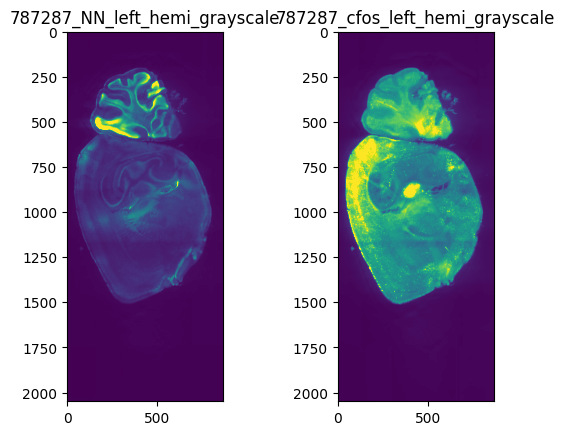

In [59]:
#explore data-- average across z axis
fig, ax = plt.subplots(nrows=1, ncols=len(combined_tifs))
for i, subfolder in enumerate(combined_tifs.keys()):
    print(f"{subfolder} tif shape (Z, Y, X):", combined_tifs[subfolder].shape)
    ax[i].imshow(combined_tifs[subfolder].mean(axis=0),vmin=0, vmax=500)
    ax[i].set_title(subfolder)

In [68]:
# https://stackoverflow.com/questions/58489679/continious-update-of-matplotlib-plot-in-jupyter
from IPython.display import display, clear_output
import ipywidgets as ipy
import matplotlib.pyplot as plt
import numpy as np

# comment/uncomment to look at figures in specific folder

folder = '787287_cfos_left_hemi_grayscale'
#folder = '787287_NN_left_hemi_grayscale'

image_stack = combined_tifs[folder]

out = ipy.Output()

# show random mesh
def update(idx):
    with out:
        clear_output()
        fig, ax = plt.subplots(figsize = (5,5))
        h = ax.imshow(image_stack[slider.value], vmin=0, vmax=500)
        # h.set_data(np.ma.masked_less_equal(image_stack[0], slider.value))
        fig.canvas.flush_events()
        fig.canvas.draw()
        plt.show()

slider = ipy.IntSlider(min = 0, max = len(image_stack)-1, orientation = 'vertical')
widget = ipy.interactive(update, idx = slider)

layout = ipy.Layout()

widgets = ipy.HBox(children=(slider, out), layout = layout)
display(widgets)

# 3. Run processing!

In [90]:
#navigate to your working directory
os.chdir(Path(working_directory))

In [93]:
!pwd
!python process.py #replace lifecanvas with the name of your working directory

/Users/ytcao/Documents/GitHub/bq3d_may18_workshop/lifecanvas
VERBOSE |15:42:14| Copying raw data to: /var/folders/47/6bm96nxd0ks5x370bsvkpghh0000gn/T/bq3d1898944a-3c4c-46f7-b562-326ba4b5ee50/1ffe6bb9-88cf-49e7-b8af-119f9349e18a.tif
VERBOSE |15:42:15| Number of chunks: 1
INFO    |15:42:15| chunk ranges: z= [0, 11], y= [0, 2049], x = [0, 867]
INFO    |15:42:15| Creating memory mapped substack at: /var/folders/47/6bm96nxd0ks5x370bsvkpghh0000gn/T/bq3d1898944a-3c4c-46f7-b562-326ba4b5ee50/run86e8d17e-1fc1-4f3c-8b6e-825c8877db56/8aa2b4f7-44a2-439b-bb94-056504a957b6.tif
INFO    |15:42:15| Creating raw substack at: /var/folders/47/6bm96nxd0ks5x370bsvkpghh0000gn/T/bq3d1898944a-3c4c-46f7-b562-326ba4b5ee50/run86e8d17e-1fc1-4f3c-8b6e-825c8877db56/ddc5e979-9359-4499-91fc-5b8cddb89d74.tif
VERBOSE |15:42:15| PixelClassification| ram: 4
VERBOSE |15:42:15| PixelClassification| processes: 1
VERBOSE |15:42:15| PixelClassification| project: /Users/ytcao/Documents/GitHub/bq3d_may18_workshop/cfos_6h_nov2.ilp

# 4. Examine analysis output